In [30]:
from nequip.ase.nequip_calculator import NequIPCalculator
from matplotlib import pyplot as plt
from ase.io import read,write 
from ase.mep import DyNEB
from ase.filters import FrechetCellFilter
from ase.optimize import FIRE 

import torch
import os, glob
import numpy as np
import pandas as pd

## Functions

In [31]:
def relax(atoms, calculator, relax_cell = False, fmax = 0.01, steps = 300):
    new_atoms = atoms.copy()
    new_atoms.calc = calculator

    if relax_cell:
        fcf = FrechetCellFilter(new_atoms)
        opt = FIRE(fcf)
        opt.run(fmax=fmax, steps=steps)
    else:
        opt = FIRE(new_atoms)
        opt.run(fmax=fmax, steps=steps)
    
    return new_atoms

def neb_relax(start, end, model_path, num_images = 5, fmax = 0.05, steps = 300):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    images = [start.copy() for i in range(num_images+1)]
    images.append(end.copy())

    neb = DyNEB(images, climb=True)

    for image in neb.images:
        image.calc = NequIPCalculator.from_compiled_model(compile_path=model_path,
                                                          device=device)

    opt = FIRE(neb)
    opt.run(fmax=fmax, steps = steps)

    return neb

def compare_structures(atoms_mlip, atoms_vasp):
    """
    Compares MLIP and VASP relaxed structures.

    Args:
        atoms_mlip (ase.Atoms): Atoms object relaxed with MLIP.
        atoms_vasp (ase.Atoms): Atoms object relaxed with VASP (ground truth).

    Returns:
        dict: A dictionary containing comparison metrics:
              - 'energy_diff' (eV): MLIP energy - VASP energy.
              - 'cell_param_diffs' (dict): Differences for a, b, c (Å) and alpha, beta, gamma (degrees).
              - 'cell_rmse' (float): Root Mean Square Error of cell parameter differences.
              - 'mean_atomic_displacement' (float, Å): Mean of atomic displacement magnitudes.
              - 'max_atomic_displacement' (float, Å): Maximum atomic displacement magnitude.
              - 'rms_atomic_displacement' (float, Å): Root Mean Square of atomic displacement magnitudes.
              - 'atomic_displacements_all' (np.array, Å): Array of all individual atomic displacement magnitudes.
    """
    results = {}

    # 1. Energy Comparison
    results['energy_diff'] = atoms_mlip.get_potential_energy() - atoms_vasp.get_potential_energy()

    # 2. Cell Geometry Comparison
    cell_mlip_params = np.array(atoms_mlip.get_cell_lengths_and_angles())
    cell_vasp_params = np.array(atoms_vasp.get_cell_lengths_and_angles())
    
    cell_param_diff_values = cell_mlip_params - cell_vasp_params
    results['cell_param_diffs'] = {
        'da': cell_param_diff_values[0], 'db': cell_param_diff_values[1], 'dc': cell_param_diff_values[2],
        'dalpha': cell_param_diff_values[3], 'dbeta': cell_param_diff_values[4], 'dgamma': cell_param_diff_values[5]
    }
    results['cell_rmse'] = np.sqrt(np.mean(cell_param_diff_values**2))

    # 3. Atomic Displacement
    if len(atoms_mlip) != len(atoms_vasp):
        raise ValueError("Atom counts differ between MLIP and VASP structures.")
    # Optional: Check if atomic numbers match if order is critical
    # if not np.all(atoms_mlip.get_atomic_numbers() == atoms_vasp.get_atomic_numbers()):
    #     print("Warning: Atomic species or their order might differ.")

    pos_mlip = atoms_mlip.get_positions()
    pos_vasp = atoms_vasp.get_positions()
    vasp_cell_matrix = atoms_vasp.get_cell() # Cell vectors as rows

    displacement_vectors_cartesian = np.zeros_like(pos_vasp)
    for i in range(len(atoms_vasp)):
        # Calculate raw displacement vector in Cartesian coordinates
        raw_cartesian_diff = pos_mlip[i] - pos_vasp[i]
        
        # Convert raw Cartesian difference to fractional coordinates relative to VASP cell
        # Solves: vasp_cell_matrix.T @ fractional_diff = raw_cartesian_diff
        fractional_diff = np.linalg.solve(vasp_cell_matrix.T, raw_cartesian_diff)
        
        # Apply Minimum Image Convention (MIC) in fractional coordinates
        fractional_diff_mic = fractional_diff - np.round(fractional_diff)
        
        # Convert MIC fractional difference back to Cartesian coordinates
        displacement_vectors_cartesian[i] = np.dot(vasp_cell_matrix.T, fractional_diff_mic)

    displacement_magnitudes = np.linalg.norm(displacement_vectors_cartesian, axis=1)
    
    results['mean_atomic_displacement'] = np.mean(displacement_magnitudes)
    results['max_atomic_displacement'] = np.max(displacement_magnitudes)
    results['rms_atomic_displacement'] = np.sqrt(np.mean(displacement_magnitudes**2))
    results['atomic_displacements_all'] = displacement_magnitudes

    return results


# Perfect

## Gather the results

In [40]:
test_post_data_path = '../data/post_vasp/MRS/post_mrs_static'
test_pre_data_path = '../data/post_vasp/MRS/post_mrs_nostatic'

pre_perf = os.path.join(test_pre_data_path,'mrs_perf')
post_perf = os.path.join(test_post_data_path, 'mrs_perf_static')

# get list of pre structures
pre_folders = [f for f in os.listdir(pre_perf) if os.path.isdir(os.path.join(pre_perf, f))]
post_folders = [f for f in os.listdir(post_perf) if os.path.isdir(os.path.join(post_perf, f))]

print("Pre Folders:", pre_folders)
print("Post Folders:", post_folders)

Pre Folders: ['Cr5Ti5V115', 'Cr4Ti7V111W4Zr2', 'Cr4Ti12V107WZr', 'Cr2Ti2V120W2Zr2', 'Cr6Ti5V107W5Zr2', 'Cr6Ti11V102W6Zr3']
Post Folders: ['Cr5Ti5V115', 'Cr3Ti5V115W3Zr2', 'Cr4Ti7V111W4Zr2', 'Cr2Ti2V120W2Zr2', 'Cr5Ti9V107W4Zr3', 'Cr6Ti11V102W6Zr3']


In [41]:
initial_atoms = {}
for folder in pre_folders:

    # first see if the outcar exists
    outcar_path = os.path.join(pre_perf, folder, 'OUTCAR')
    
    # Check if OUTCAR exists
    if os.path.exists(outcar_path):
        new_atoms = read(outcar_path, index=0)
    else:
        # If OUTCAR doesn't exist, look for the lowest (0 indexed) OUTCAR-X
        outcar_0_path = os.path.join(pre_perf, folder, 'OUTCAR-0')
        # Note: This assumes OUTCAR-0 will exist if OUTCAR does not.
        # A more robust solution might check for OUTCAR-0's existence as well.
        new_atoms = read(outcar_0_path, index=0)
    
    initial_atoms[folder] = new_atoms


In [42]:
final_vasp_atoms = {}

for folder in post_folders:

    outcar_path = os.path.join(post_perf, folder, 'OUTCAR')

    if os.path.exists(outcar_path):
        new_atoms = read(outcar_path, index=-1)
    else:
        # If OUTCAR doesn't exist, look for OUTCAR-N files and find the one with the highest suffix
        folder_path = os.path.join(post_perf, folder)
        outcar_files = [f for f in os.listdir(folder_path) if f.startswith('OUTCAR-') and f[7:].isdigit()]

        if outcar_files:
            # Find the file with the highest numerical suffix
            highest_suffix = -1
            highest_suffix_file = None
            for filename in outcar_files:
                suffix = int(filename[7:])
                if suffix > highest_suffix:
                    highest_suffix = suffix
                    highest_suffix_file = filename

            if highest_suffix_file:
                outcar_N_path = os.path.join(folder_path, highest_suffix_file)
                new_atoms = read(outcar_N_path, index=-1)
            else:
                # This case should ideally not happen if outcar_files is not empty,
                # but as a fallback or error handling:
                print(f"Warning: No OUTCAR-* files found with valid numeric suffix in {folder_path}")
                new_atoms = None # Assign None if no suitable file is found
        else:
            print(f"Warning: Neither OUTCAR nor OUTCAR-* files found in {folder_path}")
            new_atoms = None # Assign None if no OUTCAR or OUTCAR-* files exist

    final_vasp_atoms[folder] = new_atoms
    

## Run the relaxation

In [43]:
final_atoms = {}
device = "cuda" if torch.cuda.is_available() else "cpu"
calc = NequIPCalculator.from_compiled_model(compile_path='../data/potentials/gen-7-05-19_compiled_model.nequip.pt2', device=device)
for key, value in initial_atoms.items():
    relaxed_atoms = relax(value, calculator=calc, relax_cell=True, fmax=0.01)
    final_atoms[key] = relaxed_atoms

/home/myless/Packages/Triton-Allegro-Package/nequip/nequip/ase/nequip_calculator.py:137: UserWarning: Trying to use model type names as chemical symbols; this may not be correct for your model (and may cause an error if model type names are not chemical symbols)! To avoid this warning, please provide `chemical_symbols` explicitly.
  warnings.warn(


      Step     Time          Energy          fmax
FIRE:    0 16:17:27    -1111.903533        1.850247
FIRE:    1 16:17:27    -1112.000583        1.638429
FIRE:    2 16:17:27    -1112.160875        1.258496
FIRE:    3 16:17:27    -1112.335585        0.805379
FIRE:    4 16:17:27    -1112.486982        0.437524
FIRE:    5 16:17:27    -1112.603209        0.447016
FIRE:    6 16:17:27    -1112.692361        0.452549
FIRE:    7 16:17:27    -1112.768872        0.454539
FIRE:    8 16:17:27    -1112.854265        0.453785
FIRE:    9 16:17:27    -1112.959384        0.450513
FIRE:   10 16:17:27    -1113.083627        0.444685
FIRE:   11 16:17:27    -1113.207530        0.436205
FIRE:   12 16:17:27    -1113.314369        0.527970
FIRE:   13 16:17:27    -1113.439521        0.639065
FIRE:   14 16:17:27    -1113.607395        0.534112
FIRE:   15 16:17:27    -1113.781468        0.423804
FIRE:   16 16:17:27    -1113.926934        0.425199
FIRE:   17 16:17:27    -1114.058056        0.425431
FIRE:   18 16:

## Analyze the Perfect Results

Found 4 common systems: ['Cr2Ti2V120W2Zr2', 'Cr4Ti7V111W4Zr2', 'Cr5Ti5V115', 'Cr6Ti11V102W6Zr3']

Processing system: Cr2Ti2V120W2Zr2...


  Comparison successful for Cr2Ti2V120W2Zr2.

Processing system: Cr4Ti7V111W4Zr2...
  Comparison successful for Cr4Ti7V111W4Zr2.

Processing system: Cr5Ti5V115...
  Comparison successful for Cr5Ti5V115.

Processing system: Cr6Ti11V102W6Zr3...
  Comparison successful for Cr6Ti11V102W6Zr3.

--- Comparison Summary Table ---
                  energy_diff  mlip_energy_total  vasp_energy_total  num_atoms  mean_atomic_displacement  max_atomic_displacement  rms_atomic_displacement  cell_rmse      da      db      dc  dalpha   dbeta  dgamma
system                                                                                                                                                                                                               
Cr2Ti2V120W2Zr2        2.9507         -1147.4784         -1150.4292        128                    0.2933                   0.5302                   0.3097     0.2442 -0.3400 -0.3511 -0.3405  0.0221 -0.0022 -0.0508
Cr4Ti7V111W4Zr2        1.5126      

/tmp/ipykernel_84242/3240509978.py:55: DeprecationWarning: Please use atoms.cell.cellpar() instead
  cell_mlip_params = np.array(atoms_mlip.get_cell_lengths_and_angles())
/tmp/ipykernel_84242/3240509978.py:56: DeprecationWarning: Please use atoms.cell.cellpar() instead
  cell_vasp_params = np.array(atoms_vasp.get_cell_lengths_and_angles())


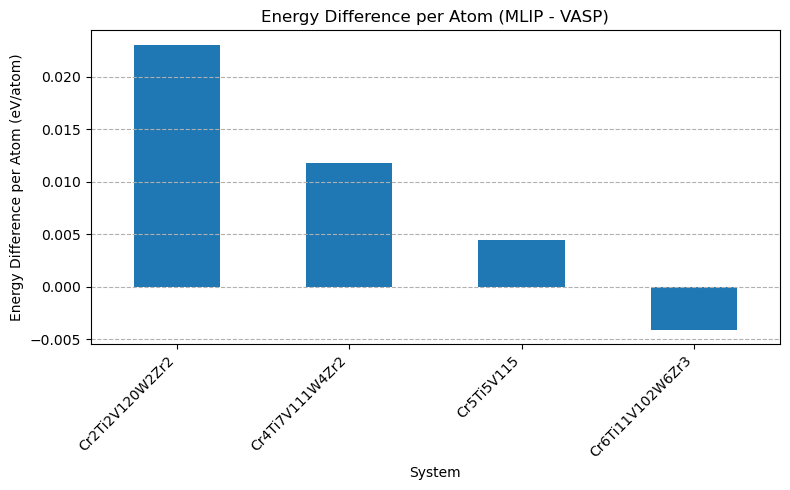

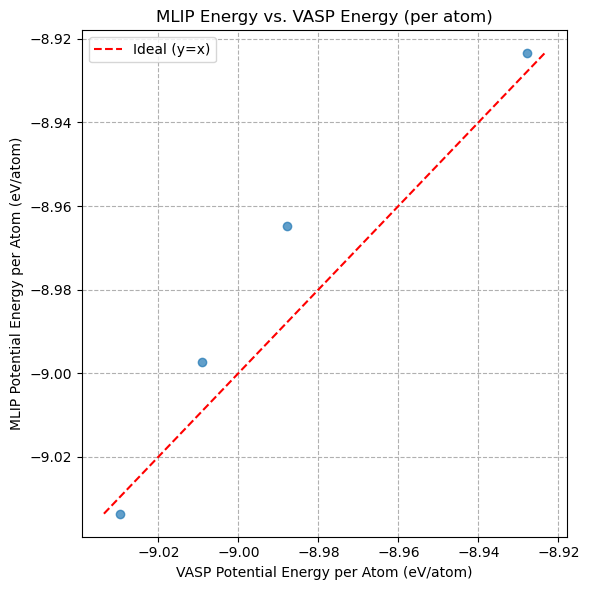

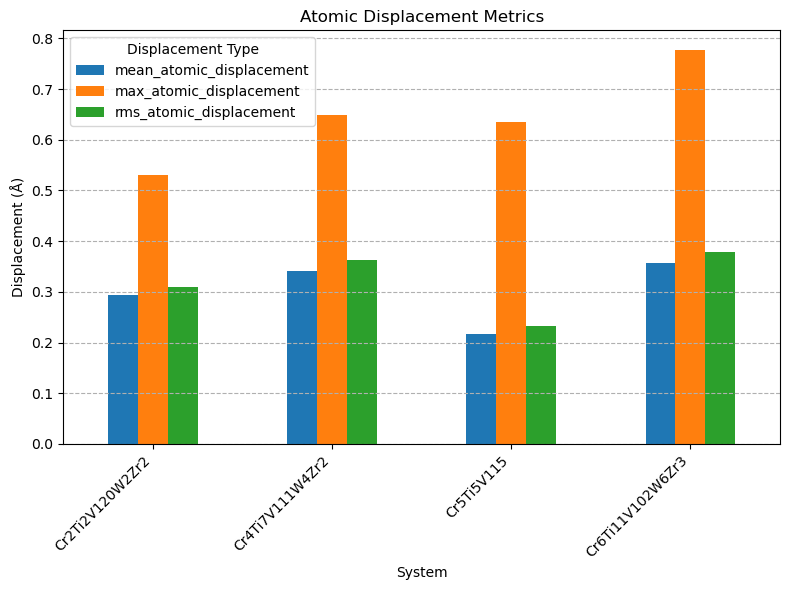

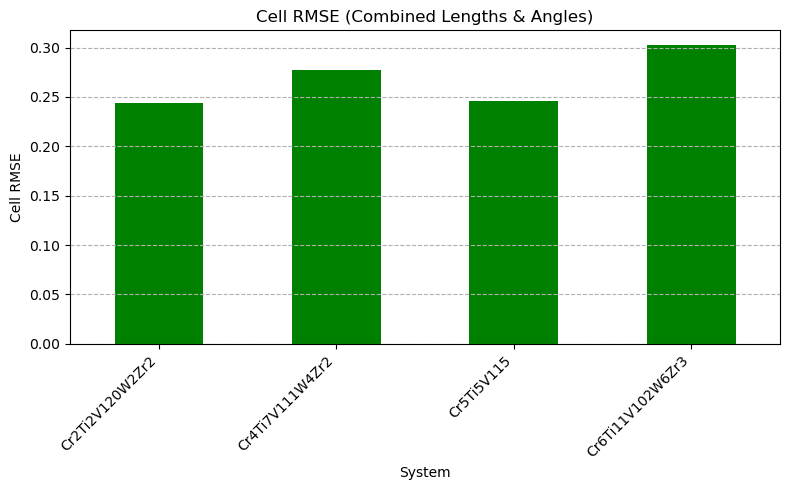

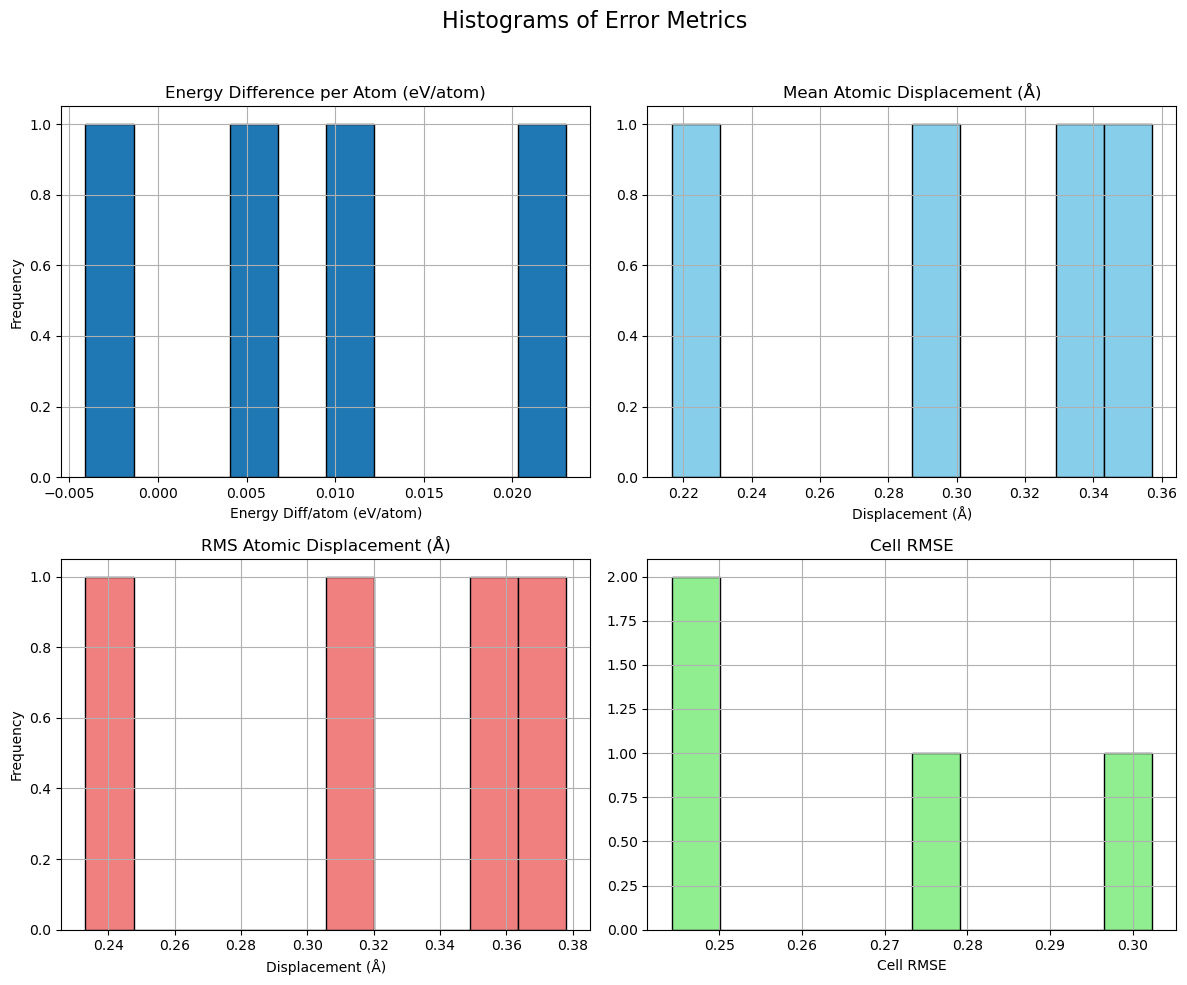

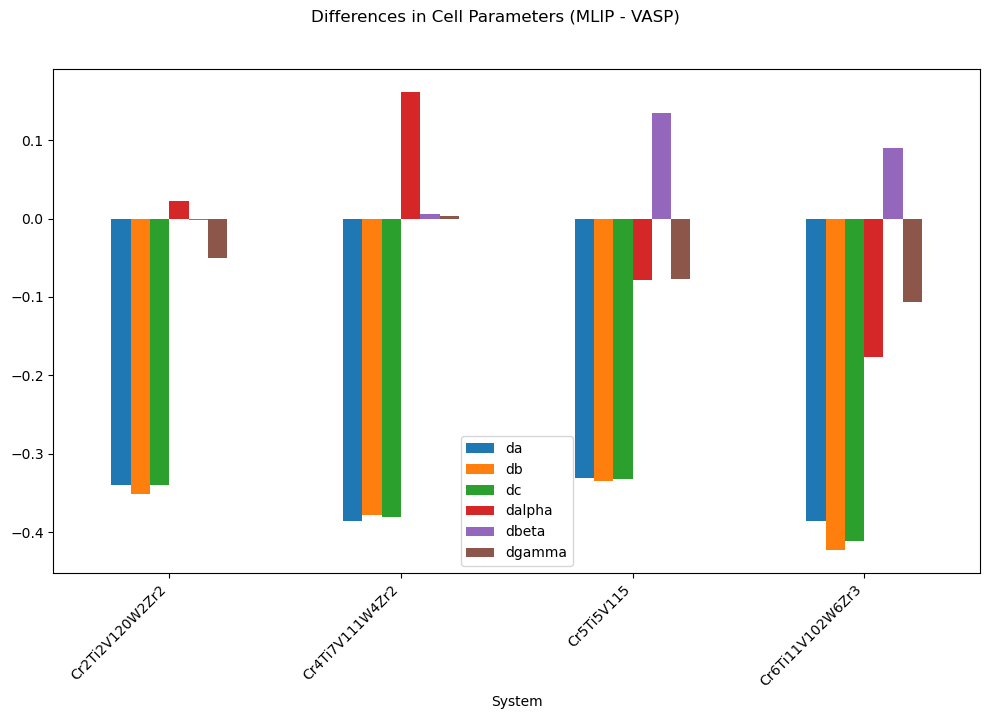


Analysis complete.


In [44]:
# --- Main processing and plotting ---
all_comparison_results_list = []
common_keys = set(final_vasp_atoms.keys()) & set(final_atoms.keys())

if not common_keys:
    print("No common keys found between final_atoms and final_vasp_atoms dictionaries.")
else:
    print(f"Found {len(common_keys)} common systems: {sorted(list(common_keys))}")
    for key in sorted(list(common_keys)): # Iterate in a consistent order
        atoms_mlip = final_atoms[key]
        atoms_vasp = final_vasp_atoms[key]
        
        print(f"\nProcessing system: {key}...")
        try:
            # This is where you need the 'compare_structures' function from the previous step
            metrics = compare_structures(atoms_mlip, atoms_vasp)
            
            # Store original energies for scatter plot later
            metrics['mlip_energy_total'] = atoms_mlip.get_potential_energy()
            metrics['vasp_energy_total'] = atoms_vasp.get_potential_energy()
            metrics['num_atoms'] = len(atoms_vasp)
            
            # Add system key to metrics dict for DataFrame creation
            metrics['system'] = key 
            all_comparison_results_list.append(metrics)
            print(f"  Comparison successful for {key}.")
        except Exception as e:
            print(f"  Error comparing system {key}: {e}")
            import traceback
            traceback.print_exc()

# Create a Pandas DataFrame from the results
if not all_comparison_results_list:
    print("\nNo comparison results to plot.")
else:
    df_results = pd.DataFrame(all_comparison_results_list)
    df_results.set_index('system', inplace=True)

    # Flatten the cell_param_diffs dictionary into separate columns
    if 'cell_param_diffs' in df_results.columns:
        cell_diffs_df = df_results['cell_param_diffs'].apply(pd.Series)
        df_results = pd.concat([df_results.drop(['cell_param_diffs'], axis=1), cell_diffs_df], axis=1)
    
    # Drop the detailed list of all atomic displacements for summary plots
    if 'atomic_displacements_all' in df_results.columns:
        df_results_summary = df_results.drop(columns=['atomic_displacements_all'])
    else:
        df_results_summary = df_results.copy()

    print("\n--- Comparison Summary Table ---")
    # Define a preferred column order for display
    display_cols = [
        'energy_diff', 'mlip_energy_total', 'vasp_energy_total', 'num_atoms',
        'mean_atomic_displacement', 'max_atomic_displacement', 'rms_atomic_displacement', 
        'cell_rmse', 'da', 'db', 'dc', 'dalpha', 'dbeta', 'dgamma'
    ]
    existing_display_cols = [col for col in display_cols if col in df_results_summary.columns]
    print(df_results_summary[existing_display_cols].to_string(float_format="%.4f"))

    # --- Plotting ---
    num_systems = len(df_results_summary)
    if num_systems == 0:
        print("\nNo data in DataFrame to plot.")
    else:
        print("\n--- Generating Plots ---")
        
        # Plot 1: Energy Difference (MLIP - VASP) per system
        plt.figure(figsize=(max(8, num_systems * 0.5), 5)) # Dynamic width
        df_results_summary['energy_diff_per_atom'] = df_results_summary['energy_diff'] / df_results_summary['num_atoms']
        df_results_summary['energy_diff_per_atom'].plot(kind='bar')
        plt.title('Energy Difference per Atom (MLIP - VASP)')
        plt.ylabel('Energy Difference per Atom (eV/atom)')
        plt.xlabel('System')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

        # Plot 2: Scatter plot of MLIP Energy vs VASP Energy (per atom)
        plt.figure(figsize=(6, 6))
        mlip_energy_pa = df_results_summary['mlip_energy_total'] / df_results_summary['num_atoms']
        vasp_energy_pa = df_results_summary['vasp_energy_total'] / df_results_summary['num_atoms']
        plt.scatter(vasp_energy_pa, mlip_energy_pa, alpha=0.7)
        # Add y=x line for reference
        min_val = min(vasp_energy_pa.min(), mlip_energy_pa.min())
        max_val = max(vasp_energy_pa.max(), mlip_energy_pa.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y=x)')
        plt.title('MLIP Energy vs. VASP Energy (per atom)')
        plt.xlabel('VASP Potential Energy per Atom (eV/atom)')
        plt.ylabel('MLIP Potential Energy per Atom (eV/atom)')
        plt.legend()
        plt.grid(True, linestyle='--')
        plt.tight_layout()
        plt.show()

        # Plot 3: Mean, Max, and RMS Atomic Displacement
        displacement_metrics = ['mean_atomic_displacement', 'max_atomic_displacement', 'rms_atomic_displacement']
        if all(metric in df_results_summary.columns for metric in displacement_metrics):
            df_results_summary[displacement_metrics].plot(kind='bar', figsize=(max(8, num_systems * 0.8), 6))
            plt.title('Atomic Displacement Metrics')
            plt.ylabel('Displacement (Å)')
            plt.xlabel('System')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--')
            plt.legend(title="Displacement Type")
            plt.tight_layout()
            plt.show()
        else:
            print("Skipping displacement bar plot due to missing columns.")


        # Plot 4: Cell RMSE
        if 'cell_rmse' in df_results_summary.columns:
            plt.figure(figsize=(max(8, num_systems * 0.5), 5))
            df_results_summary['cell_rmse'].plot(kind='bar', color='green')
            plt.title('Cell RMSE (Combined Lengths & Angles)')
            plt.ylabel('Cell RMSE')
            plt.xlabel('System')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()
            plt.show()
        else:
            print("Skipping cell RMSE plot due to missing column.")

        # Plot 5: Histograms of key error metrics (if enough data points)
        if num_systems > 1: # Histograms make more sense with multiple data points
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            fig.suptitle('Histograms of Error Metrics', fontsize=16)

            if 'energy_diff_per_atom' in df_results_summary.columns:
                df_results_summary['energy_diff_per_atom'].hist(ax=axes[0,0], bins=max(10, num_systems // 2), edgecolor='black')
                axes[0,0].set_title('Energy Difference per Atom (eV/atom)')
                axes[0,0].set_xlabel('Energy Diff/atom (eV/atom)')
                axes[0,0].set_ylabel('Frequency')
            
            if 'mean_atomic_displacement' in df_results_summary.columns:
                df_results_summary['mean_atomic_displacement'].hist(ax=axes[0,1], bins=max(10, num_systems // 2), edgecolor='black', color='skyblue')
                axes[0,1].set_title('Mean Atomic Displacement (Å)')
                axes[0,1].set_xlabel('Displacement (Å)')
            
            if 'rms_atomic_displacement' in df_results_summary.columns:
                df_results_summary['rms_atomic_displacement'].hist(ax=axes[1,0], bins=max(10, num_systems // 2), edgecolor='black', color='lightcoral')
                axes[1,0].set_title('RMS Atomic Displacement (Å)')
                axes[1,0].set_xlabel('Displacement (Å)')
                axes[1,0].set_ylabel('Frequency')

            if 'cell_rmse' in df_results_summary.columns:
                df_results_summary['cell_rmse'].hist(ax=axes[1,1], bins=max(10, num_systems // 2), edgecolor='black', color='lightgreen')
                axes[1,1].set_title('Cell RMSE')
                axes[1,1].set_xlabel('Cell RMSE')

            plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
            plt.show()
        elif num_systems == 1:
            print("\nSkipping histograms as there is only one system.")
        
        # Optional: Individual cell parameter differences (da, db, etc.)
        cell_param_cols = ['da', 'db', 'dc', 'dalpha', 'dbeta', 'dgamma']
        existing_cell_param_cols = [col for col in cell_param_cols if col in df_results_summary.columns]
        if existing_cell_param_cols and num_systems > 0:
            df_results_summary[existing_cell_param_cols].plot(kind='bar', subplots=False, figsize=(max(10, num_systems * 1), 7), sharex=True)
            plt.suptitle('Differences in Cell Parameters (MLIP - VASP)', y=1.02)
            plt.xlabel('System')
            # Y-axis label is tricky here because units are mixed (Å and degrees)
            # plt.ylabel('Difference') 
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("Skipping cell parameter difference plot (no data or columns missing).")

print("\nAnalysis complete.")

# Vacancy

# NEB